In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append('../')
from galaxybrain import ramsey, ising

import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import pandas as pd
import time
from IPython.display import clear_output

# Starting from scratch
using [this](https://www.asc.ohio-state.edu/braaten.1/statphys/Ising_MatLab.pdf)<br>
Hamiltonian – rate of change in time of the condition of a dynamic physical system, or total energy in the system – is given by

\\[ H = -J\sum_{ij} s_is_j \\] 

Summing interactions between [4] neighbors, J (Strength of interaction in Joules) is usually 1 <br>
"In the case of an Ising system, instead of moving a particle, we switch the direction of its spin."

In each monte carlo sweep:
- "Propose" a move: (done in aggregate for each particle)
    - if ∆E < 0  (i.e., the move would bring the system to a state of lower energy; this is desired in physical systems), accept it
    - if ∆E > 0, accept move with probability exp(-∆E/kT) where k is Joules per kelvin.

let's try to do this vectorized

Furnstahl:  multiply every transition probability by 0.1 to avoid undesirable oscillatory regimes

In [2]:
mouse1 = ising.metro_ising(N=650,T=2.26918531421, plot=False,runtime=1000)
mouse1_slice = pd.DataFrame(mouse1[200:][:,325])

In [5]:
mouse1_slice.shape

(800, 650)

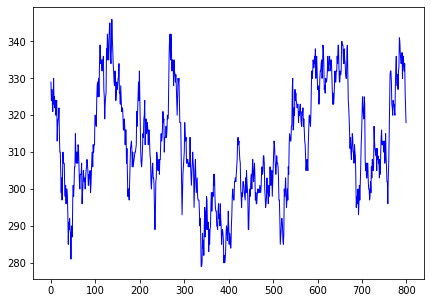

In [8]:
plt.figure(figsize=(7,5)); plt.plot(np.sum(mouse1_slice.T),'blue',lw='1')

/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


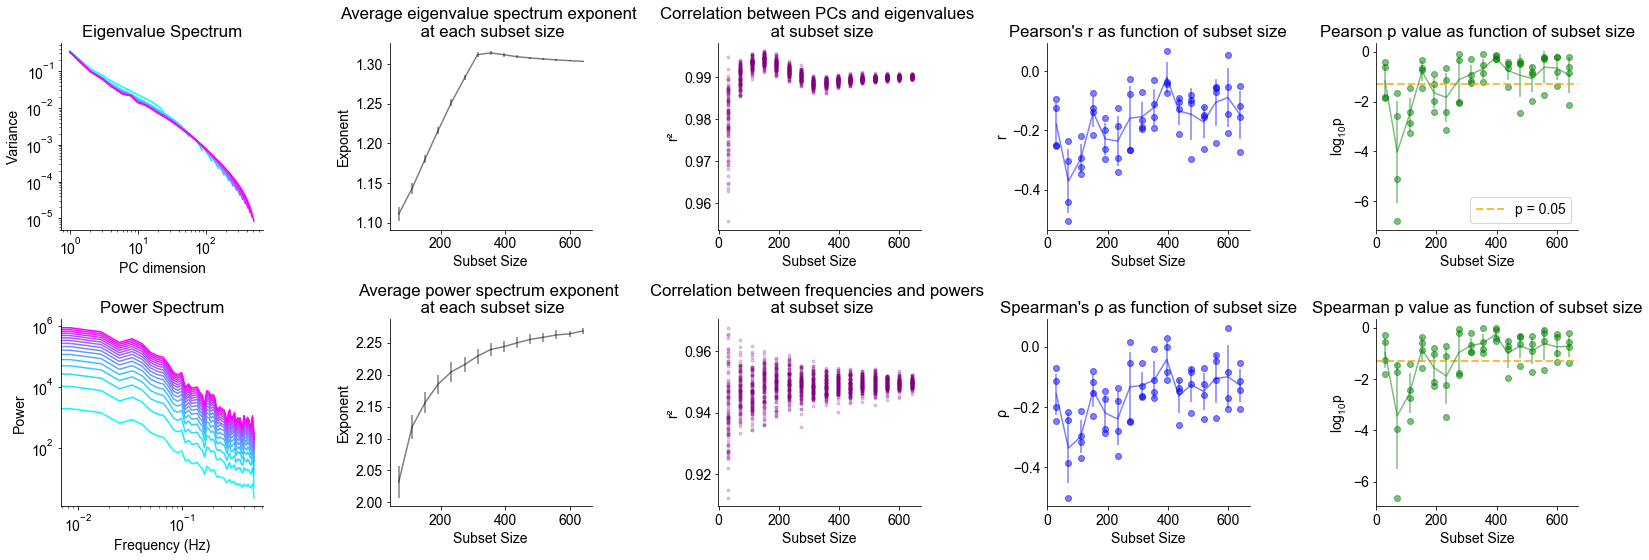

In [78]:
mouse1 = metropolis_ising(N=650,T=2.26918531421, plot=False,runtime=1000)
mouse1_slice = pd.DataFrame(mouse1[200:][:,325])
subsetsizes = np.linspace(30,640,16, dtype=int)
n_iters = 95; n_pc = 0.8; f_range = [0,0.4]; pc_range = [0,0.7]
decomp_arr = []
for i in range(4):
    eigs, pows, pca_m, s_r2, ft_m, t_r2, psn_r, spn_r, psn_p, spn_p = ramsey.ramsey(mouse1_slice.T, subsetsizes, n_iters = 95, n_pc = 0.8, f_range = [0,0.4], verbose = False)
    decomp_arr.append([pca_m, ft_m, psn_r, spn_r, psn_p, spn_p])
decomp_arr = np.array(decomp_arr)
ramsey.plot_all_measures(subsetsizes, s_r2, t_r2, n_iters, n_pc, f_range, pc_range, eigs, pows,decomp_arr[:,0].mean(0), decomp_arr[:,1].mean(0), decomp_arr[:,2], decomp_arr[:,3], decomp_arr[:,4], decomp_arr[:,5])

/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


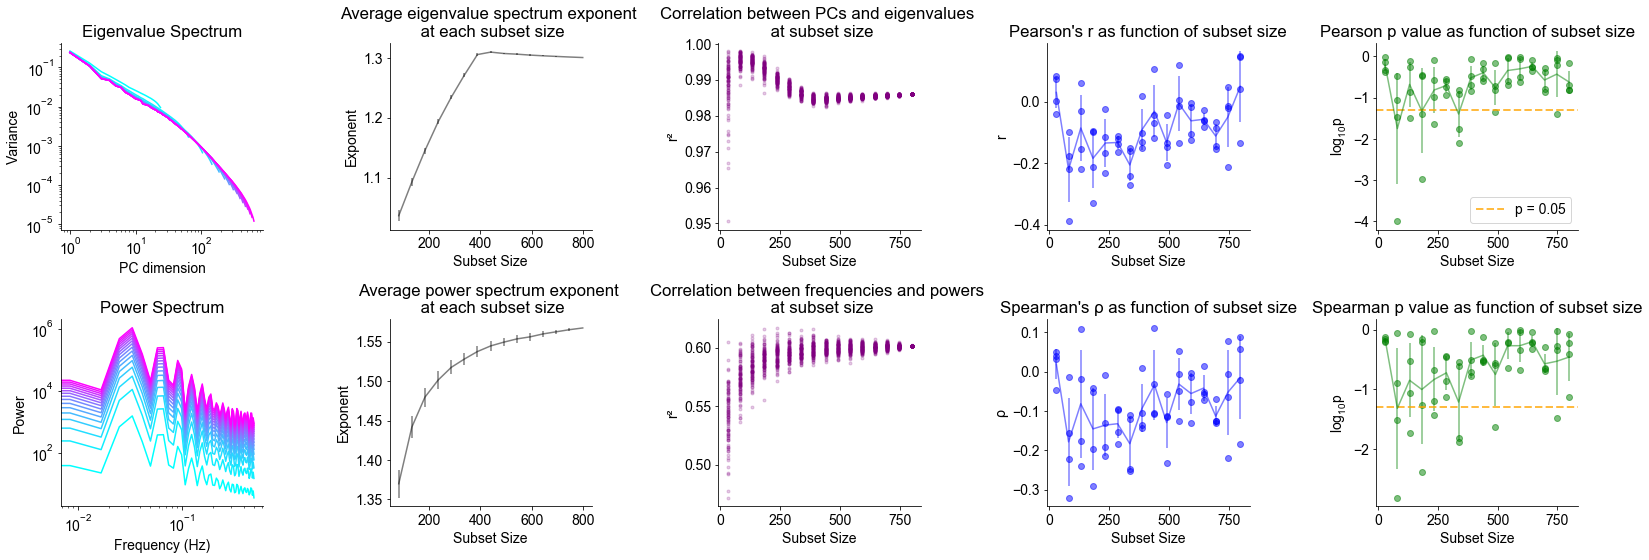

In [34]:
mouse1 = metropolis_ising(N=32,T=2.26918531421, plot=False,runtime=1000) # NOTE: this was using flattened frames
subsetsizes = np.linspace(30,799,16, dtype=int)
n_iters = 95; n_pc = 0.8; f_range = [0,0.4]; pc_range = [0,None]
decomp_arr = []
for i in range(4):
    eigs, pows, pca_m, s_r2, ft_m, t_r2, psn_r, spn_r, psn_p, spn_p = ramsey.ramsey(mouse1[200:].T, subsetsizes, n_iters = 95, n_pc = 0.8, f_range = [0,0.4], verbose = False)
    decomp_arr.append([pca_m, ft_m, psn_r, spn_r, psn_p, spn_p])
decomp_arr = np.array(decomp_arr)
ramsey.plot_all_measures(subsetsizes, s_r2, t_r2, n_iters, n_pc, f_range, pc_range, eigs, pows,decomp_arr[:,0].mean(0), decomp_arr[:,1].mean(0), decomp_arr[:,2], decomp_arr[:,3], decomp_arr[:,4], decomp_arr[:,5])

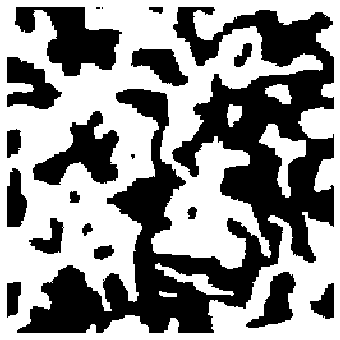

In [7]:
x= ising.metro_ising(N=256,T=0.1,runtime=500,plot='static')